# The Variational Method with the 2D Rigid Rotor with HF

For the external field applied to a diatomic molecule with a dipole moment:

$$
V_{external} = -\mathbf{E} \cdot \boldsymbol{\mu}_z = g \cos{\theta}
$$

Where $V_{external}$ is potential, $\mathbf{E}$ is the external electric field, $\boldsymbol{\mu}_z$ is the dipole moment of the molecule, and g is dependent on the strength of both components.

$\boldsymbol{\mu}_z$ is usually reported in Debye, so convert to Coulomb meters, should be very small.  Also, make sure to convert masses to atomic units, since the equation will go awry otherwise.

$$
\Phi_{trial} = e^{i\alpha \theta}+e^{i\beta \theta}
$$

where $\alpha$ and $\beta$ are real-valued parameters.

Since a diatomic molecule is being considered, it only makes sense to use the 2D rigid rotor model for the trial wavefunction.

$$
\hat{H}=-\frac{\hbar^2}{2\mu R^2}\frac{\partial^2}{\partial \theta^2} + V_{external}
$$

$$ E[\Phi(\theta, \alpha, \beta)] = \frac{\int_0^{2\pi} \phi^*(\theta, \alpha, \beta) \hat{H} \phi(\theta, \alpha, \beta) \, d\theta}
{\int_0^{2\pi} \phi^*(\theta, \alpha, \beta) \phi(\theta, \alpha, \beta) \, d\theta} $$

To start, a test molecule will be used, and atomic units will be used for ease of calculating.

## Importing constants and tools...

In [ ]:
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import ipywidgets as widgets
from IPython.display import display
import math


## JJF Comment: Are these reference values used later?  If not, consider removing, and if so, clarify their purpose.
# the masses of HF
_reference_mu_HF = 0.95
# _reference_mass_H1 = 1.0080
# _reference_mass_F19 = 18.998
_reference_mass_H1 = 1.67
_reference_mass_F19 = 18.998

## Setting up Functions

JJF Comment: Add some text that briefly explains what each function below is for.

In [ ]:
# allows for changing the value of mu, just define masses 1 and 2 below!
def compute_reduced_mass(mass_a, mass_b):
    mu = (mass_a * mass_b) / (mass_a + mass_b)
    return mu
# mass_1 = _reference_mass_H1
# mass_2 = _reference_mass_F19
# in this case, we're using HF, so that is defined in the next block

# converts mu into atomic units (a.u.)
def kg_to_au(any_mu):
    mu_au = any_mu/(9.1093837139E-31) ### JFF Comment: Consider using constants.electron_mass for clarity
    return mu_au

# trial wavefunction creation tool
def trial_wf(a, b, theta_t):
    return np.exp(1j * a * theta_t) + np.exp(1j * b * theta_t)

### considder adding a function called trial_wf_second_deriv to compute the second derivative of the trial wavefunction
def trial_wf_second_deriv(a, b, theta_t):
    ### insert code to compute second derivative of trial wavefunction

def probability_density(wf, theta_list):
    # compute density for all points
    density_list = (wf.conj() * wf).real

    # normalize
    norm_factor = np.trapezoid(density_list, theta_list)
    density = density_list / norm_factor

    return density

def dfdx(ft, xt):
    dx = xt[1]-xt[0]
    ftp= np.zeros_like(ft)
    for i in range(0, len(ft)):
        if (i<(len(ft)-1)):
            rise = ft[i+1]-ft[i]
            ftp[i] = rise/dx
        else:
            rise = ft[i] - ft[i-1]
            ftp[i] = rise/dx

    return ftp

# Debye to Coulomb Meters (for mu_z)
### JJF Comment: Is this needed?  It looks like you
### input the dipole moment in atomic units later
def Deb_to_Cm(any_mu_z):
    mu_Cm = any_mu_z*(3.33564E-30)
    return mu_Cm

# Angstrom to Bohr conversion (for R)
def Angstrom_to_Bohr(any_length):
    bohr = any_length / 0.529 ### JJF Comment: Consider using constants.value('Bohr radius') for clarity
    return bohr


## Values Defined
For computation, it is generally easier to work in atomics units and convert back into standard units at the end.  For example, $\hbar$ is 1 in atomic units.

Recall that the formulas we're working with have the following values in them:

$\theta$: angle, varies from 0 to 2$\pi$ radians

$\mathbf{E}$: external electric field, is constant in this case

$\boldsymbol{\mu}_z$: dipole moment of the molecule, is constant

$\mu$: reduced mass of the molecule, is constant

$i$: $\sqrt{-1}$, not to be confused with the index i

$\hbar$: Planck's constant divided by 2$\pi$, a constant

$\alpha$: a parameter, an arbitrary real value

$\beta$: a parameter, an arbitrary real value

Since a majority of these values are constants, they can be hard-coded, but the values that vary have to be included using arrays.

In [ ]:

### Constants
# electric field
E = 1
# since we're working in atomic units,
hbar = 1
# we're using HF here
HF_mu = compute_reduced_mass(_reference_mass_H1, _reference_mass_F19)
mu = kg_to_au(HF_mu)
# similarly for radius R in Bohr
HF_A = 0.92
HF_b = Angstrom_to_Bohr(HF_A)
R = HF_b
# dipole moment in Coulomb meters
mu_z_HF = 1.82
mu_z = Deb_to_Cm(mu_z_HF)

# for i, just use 1j

### Variable Values
# 0 to 2pi radians with 5,000 values
theta = np.linspace(0, 2*np.pi, 5000)
# alpha and beta will be adjusted with sliders


## Defining the Hamiltonian and Functionals

In [ ]:

mu = 1756.0984965101616                       # reduced mass
r = 0.48668000000000006                         # distance between atoms
I = mu * r **2                # orbital angular momentum
mu_z = 1.82                   # dipole moment
e_field = 1.0                   # electric field

g = mu_z * e_field

# unperturbed Hamiltonian
def H0(phi, theta_t):
    ftp = dfdx(phi, theta_t)
    ftpp = -1/(2*I) * dfdx(ftp, theta_t)
    return ftpp

# external electric field
def V_ex(phi, theta):
    v_ft = - g * np.cos(theta) * phi
    return v_ft

# functional for H0
def H0_functional(phi, theta_t):
    tphi = H0(phi, theta_t)
    num = phi.conj() * tphi
    denom = phi.conj() * phi
    num_int = np.trapezoid(num, theta)
    denom_int = np.trapezoid(denom, theta)

    E_H0 = (num_int/denom_int).real
    return E_H0

# functional external electric field
def V_ex_functional(phi, theta_t):
    tphi = V_ex(phi, theta_t)
    num = phi.conj() * tphi
    denom = phi.conj() * phi
    num_int = np.trapezoid(num, theta)
    denom_int = np.trapezoid(denom, theta)

    V_e = (num_int/denom_int).real
    return V_e

# calculates energy
def E_calc(phi, theta_t):
    E = H0_functional(phi, theta_t) + V_ex_functional(phi, theta_t)
    return E

# energy functional
def E_functional(alpha, beta, theta_t):
    e_list = []
    for i in alpha:
        for j in beta:
            wf = trial_wf(i, j, theta_t)
            e = E_calc(wf, theta_t)
            e_list.append(e)

    return e_list

## A Plot to Showcase Parameters with Functional

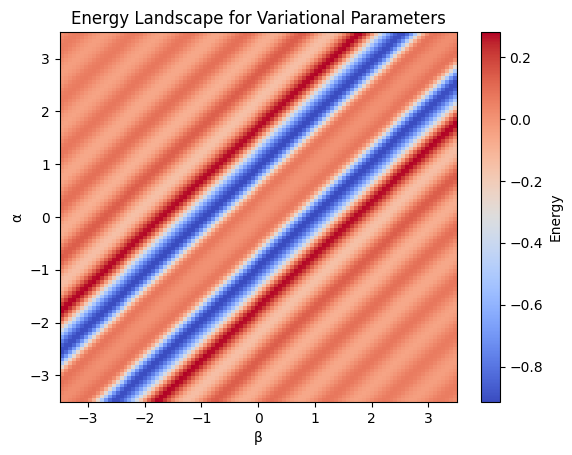

In [ ]:
alphas = np.linspace(-3.5, 3.5, 100)
betas = np.linspace(-3.5, 3.5, 100)

e_vals = E_functional(alphas, betas, theta)
e_array = np.array(e_vals).reshape(len(alphas), len(betas))

plt.imshow(e_array, extent=[betas[0], betas[-1], alphas[0], alphas[-1]],
           origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Energy')
plt.xlabel('β')
plt.ylabel('α')
plt.title('Energy Landscape for Variational Parameters')
plt.show()

## Interactive Plot to See Effects of Parameters on the Wavefunction

In [ ]:
# Find the index of minimum energy
min_idx = np.unravel_index(np.argmin(e_array), e_array.shape)

# Get the corresponding alpha and beta values
alpha_min = alphas[min_idx[0]]
beta_min = betas[min_idx[1]]
min_energy = e_array[min_idx]

v_vals = -g * np.cos(theta) *1e-2

# ipywidget to change alpha and beta
def interactive_with_optimal():
    alpha_slider = widgets.FloatSlider(value=alpha_min, min=-3.5, max=3.5, step=0.1, description='α:')
    beta_slider = widgets.FloatSlider(value=beta_min, min=-3.5, max=3.5, step=0.1, description='β:')

    optimal_button = widgets.Button(description='Set to Optimal', button_style='success')

    def set_optimal(b):
        alpha_slider.value = alpha_min
        beta_slider.value = beta_min

    optimal_button.on_click(set_optimal)

    def plot_density(alpha, beta):
        wf = trial_wf(alpha, beta, theta)
        density = probability_density(wf, theta)
        energy = E_calc(wf, theta)

        plt.plot(np.array(theta)/np.pi, density, 'b-', linewidth=2, label='Probability Density')
        plt.plot(np.array(theta)/np.pi, v_vals, 'r--', alpha=0.5, label='Potential')
        plt.xlabel('θ/π', fontsize=12)
        plt.ylabel('Probability Density', fontsize=12)
        plt.title(f'α={alpha:.2f}, β={beta:.2f}, E={energy:.6f}', fontsize=14)
        plt.legend()
        plt.tight_layout()
        plt.show()

    interactive_plot = widgets.interactive_output(plot_density, {'alpha': alpha_slider, 'beta': beta_slider})

    display(widgets.VBox([
        widgets.HBox([alpha_slider, beta_slider, optimal_button]),
        interactive_plot
    ]))

interactive_with_optimal()